# ADA Project
<br><br>

----
### Subject: 
finding what influence the number of protests among: area of the country, population density, net migration, infant mortality, deathrate, income group, climate, etc.  
<br><br>

----
### Objective: 
finding what to change in a country to decrease the number of protests (assuming that a less number of protests means that the inhabitants are happier)
<br><br>

----
### Summary:
First, we will get all the data we need. Second we will find a way to display data on a world map to visualize the number of protests around the world. Then, we will try to find the impact of many variables on this number of protests.
<br><br>

----
### Data explanations:
Please see the read me, section Dataset / 4- Data description to see data explanations

Here a brief explanation:

We are using the data available at the following link: https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events This is a context of **big data**: around **400 000 000** of rows.
<br><br>
- ##### <u>eventcodes.csv</u>

As we are interested in protest as kind of event, we need to find the event code associated to the protest events: **eventcodes.csv** gives us this data.
<br><br>
- ##### <u>country_by_income.csv and countries_stats.csv</u>

Then, we need to get data on all the countries to find the impact of their characteristics on the number of protests: **country_by_income.csv** and **countries_stats.csv** give us what we need. Thanks to these files, we have access to: the average income, area of the country, population density, net migration, infant mortality, deathrate, climate, etc of each country.
Got from: http://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html and https://www.kaggle.com/fernandol/countries-of-the-world/version/1

<br><br>
Let's see the **countries_stats.csv** file:

data got from: https://www.kaggle.com/fernandol/countries-of-the-world/version/1

Data available: `Country`, `Region`, `Population`, `Area (sq. mi.)`, `Pop. Density (per sq. mi.)`, `Coastline (coast/area ratio)`, `Net migration`, `Infant mortality (per 1000 births)`, `GDP ($ per capita)`, `Literacy (%)`, `Phones (per 1000)`, `Arable (%)`, `Crops (%)`, `Other (%)`, `Climate`, `Birthrate`, `Deathrate`, `Agriculture`, `Industry`, `Service`.

Most of the variables don't need to be explain as `population`, `Area (sq. mi.)`, `Infant mortality`, etc. As we wordered the meaning of `climate`, here the explanation we found:

Meaning of `climate`: 1= Dry tropical, 2= Wet tropical, 3= Temperate humid subtropical and temperate continental, 4= Dry hot summers and wet winters
<br><br>
- ##### <u>country_codes_iso2_to_iso3.csv and country_code_to_name.csv</u>

Each data define the country in a different way: code in `ISO2` or `ISO3` or with the `country name`. We need to convert each ones with the same convention. For example, to define the United-States of America, the csv files use "USA", "US" or "United-States of America". 
**country_codes_iso2_to_iso3.csv** and **country_code_to_name.csv** allow us to achieve these conversions.
there are from: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
<br><br>

- ##### <u>GDP growth world bank.csv and GINI per country worldbank.csv</u> (<a> https://data.worldbank.org </a>)
These two dataset are the estimations of the Gross Domestic Product (GDP) and the Index of Inequality (GINI) for each country , from 1960 to 2017. These datasets will be usefull economical and social indicator to understand the protestation in different countries.
(Higher index is better)

- ##### <u>DataCorruptionPerceptionIndex2000_2017.xlsx</u> (<a>https://www.transparency.org</a>)
This data set shows the estimated Corruption index (political and buisness corruption) for each country from 2000 to 2017. 
(Lower index is better)

- ##### <u>Human Development Index (HDI).csv</u> (<a> http://hdr.undp.org/en/data </a>)
Dataset of the HDI for each country from 1990 to 2017.
HDI a good indicator of the life expectancy and education of people in the country.
The definition of HDI from wikipedia:
"The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators"
(Higher index is better)



- ##### <u>World press freedom.csv
</u> (<a> https://rsf.org/fr/donnees-classement </a>)(<a> https://en.wikipedia.org/wiki/Press_Freedom_Index </a>)
This data-set shows the score of each country concerning the press freedom from 2002 to 2018
(Lower index is better)



----
### Next steps until Dec. 16
Please see the read me, section "A list of internal milestones until Dec. 16" or the end of the notebook as asked here: https://dlab.epfl.ch/teaching/fall2018/cs401/projects/

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
import json
import folium
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression, LogisticRegression
from branca.colormap import linear

from scipy import stats
from functions.folium_functions import folium_map
from functions.stats_functions import *


DATA_PATH = "data/"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\bronner\Dropbox\\ADATTC-8869006f93d1.json'
# get json by following (Setting up authentication)
# https://cloud.google.com/bigquery/docs/reference/libraries

In [2]:
bigquery_client = bigquery.Client()

# Getting the main tables:

- event codes table
- indication of richness per inhabitant per country
- Protests for leadership change
- Protests for rights
- country codes table
- country codes conversion iso2 to iso3
- statistics on countries

### Event codes:

In [3]:
event_codes = pd.read_csv(DATA_PATH + "eventcodes.csv", encoding = "ISO-8859-1")

### Indication of richness per inhabitant per country per year:

In [4]:
country_by_income_per_year = pd.read_csv(DATA_PATH + "country_by_income.csv", encoding = "ISO-8859-1")

In [5]:
country_by_income_per_year=country_by_income_per_year.dropna()
#here we only get an indicator of the income, we need to transform it to process it
#we choose to transform Low income (L) to 1, (LM) to 3, (UM) to 4, (H) to 6
country_by_income_per_year=country_by_income_per_year.replace('Low income (L)', '1')
country_by_income_per_year=country_by_income_per_year.replace('Lower middle income (LM)', '3')
country_by_income_per_year=country_by_income_per_year.replace('Upper middle income (UM)', '4')
country_by_income_per_year=country_by_income_per_year.replace('High income (H)', '6')
country_by_income_per_year['Income Group']=country_by_income_per_year['Income Group'].astype(int)

### Getting all protests events:
With:
- ##### <u> ID </u>
- ##### <u> CountryCode </u>
- ##### <u> EventCode </u>
- ##### <u> Year </u>


# Has changed

In [6]:
reload = False
if os.path.isfile(DATA_PATH + 'protests_df_raw.csv') and not reload :
    protests_df_raw = pd.read_csv(DATA_PATH + 'protests_df_raw.csv')
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode, Year, NumMentions, NumSources, NumArticles, AvgTone, MonthYear
        FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '14%' """)
    protests_df_raw = query_protests.result().to_dataframe()
    # Write down the csv
    protests_df_raw.to_csv(DATA_PATH + 'protests_df_raw.csv', index=False)
protests_df = protests_df_raw.dropna()

reload data


In [7]:
#laod for violent protest
reload = False
if os.path.isfile(DATA_PATH + 'violent_protests_df_raw.csv') and not reload :
    violent_protests_df_raw = pd.read_csv(DATA_PATH + 'violent_protests_df_raw.csv')
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode, Year, NumMentions, NumSources, NumArticles, AvgTone, MonthYear
        FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '145%' """)
    violent_protests_df_raw = query_protests.result().to_dataframe()
    # Write down the csv
    violent_protests_df_raw.to_csv(DATA_PATH + 'violent_protests_df_raw.csv', index=False)
violent_protests_df = violent_protests_df_raw.dropna()


In [8]:
print("Number of rows we got: " + str(protests_df_raw['CountryCode'].count()))

Number of rows we got: 3788777


### Country codes conversion between :
- fips104,  iso2 and iso3
- iso3 and name:

In [9]:
#Getting conversion between fips104 and iso2 code for countries
country_codes_fips104_to_iso = pd.read_csv(DATA_PATH + "fips104_to_iso.csv", encoding = "ISO-8859-1")

#Getting conversion between iso2 and iso3 code for countries
country_codes_iso2_to_iso3 = pd.read_csv(DATA_PATH + "country_codes_iso2_to_iso3.csv", encoding = "ISO-8859-1")

#merging the two data to convert from Fips 104 to ISO3
country_codes_fips104_to_iso3 = pd.merge(country_codes_fips104_to_iso, country_codes_iso2_to_iso3, how='inner',\
                                         left_on=['ISO 3166'], right_on=['ISO'])[['FIPS 10-4', 'ISO3']]

# Getting conversion between country code and country name
country_codes_to_name = pd.read_csv(DATA_PATH + "country_lat_long.csv", encoding = "ISO-8859-1")
country_codes_to_name.rename(index=str, columns={"ISO3": "Country Code"}, inplace=True)
# country_codes_to_name.columns = ['Country Name', 'ISO2', 'Country Code', 'Numeric code', 'Latitude', 'Longitude']

In [10]:
country_codes_to_name.head()

,Country Name,ISO2,Country Code,Numeric code,Latitude,Longitude
0,Albania,AL,ALB,8,41.0000,20.0
1,Algeria,DZ,DZA,12,28.0000,3.0
2,American Samoa,AS,ASM,16,-14.3333,-170.0
3,Andorra,AD,AND,20,42.5000,1.6
4,Angola,AO,AGO,24,-12.5000,18.5


### Getting statistics on countries:

In [11]:
#Getting data about statistics on all the countries
countries_stats = pd.read_csv(DATA_PATH + "countries_stats.csv", encoding = "ISO-8859-1")

# Let's start we our first visualizations:

### Visualizing average income per country on a world map

In [12]:
countries_topodata = json.load(open('data/countries.topojson.json'))

In [13]:
#getting the data from 2017
country_by_income_2017 = country_by_income_per_year[country_by_income_per_year['Year'] == 2017]

In [14]:
#Displaying a map to visualize average income per country in the world
min_value = country_by_income_2017['Income Group'].min()
max_value = country_by_income_2017['Income Group'].max()
colormap = linear.YlGn_09.scale(min_value, max_value)
colormap.caption = 'Income per cap in 2017 (Low = 1, High = 6)'
location=[46.9,8.25]
x = 'Country Code'
y = 'Income Group'

results_map_income = folium_map(country_by_income_2017, x, y, location, countries_topodata, colormap, zoom=1)

results_map_income.save('results_map_income.html')
display(HTML("<h1><a href='results_map_income.html' target='_blank'>results_map_income (Ctrl+Click)</a></h1>"))

results_map_income

Here, thanks to our visualization, we can estimate in which country the inhabitants have a better standard of living. Without any surprise, it's in the North America and in Europe

### Displaying percentage of protests on a world map

In [15]:
#join the protests dataframe to get the iso3 convention for each country
protests_df=pd.merge(protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])

Text(0, 0.5, 'Countries number')

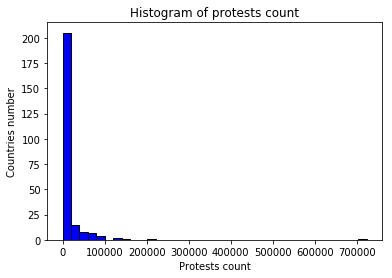

In [16]:
#changing the column name to keep the same naming convention in each dataframe
protests_df=protests_df.rename(index=str, columns={"ISO3": "Country Code"})

#counting the number of protests we have in each country
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

#Getting the distribution of protests count
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')


The distribution show that few countries have a very high number of protests. These countries, with a very high number, hids the nuance between other countries.

For instance, if a country A has 1 protests, a country B has 5000 protests and country C has 100 000 protests, we won't see any difference between country A and B in the visualization. A threshold or a log scale can resolve this issue.
We choose the log scale.

In [17]:
number_of_protests_per_country['log protests count'] = np.log10(number_of_protests_per_country['protests count'])

Visualizing result for log scale that allows to avoid loosing nuance between low values and between high values:

In [18]:
max_nb_protests = number_of_protests_per_country['protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005'
location=[46.9,8.25]
x = 'Country Code'
y = 'protests count'

results_map_protests = folium_map(number_of_protests_per_country, x, y, location, countries_topodata, colormap, zoom=1)

results_map_protests.save('results_map_protests.html')
display(HTML("<h1><a href='results_map_protests.html' target='_blank'>Map which displays the number of protests (Ctrl+Click)</a></h1>"))

results_map_protests

### Same map in log scale

In [19]:
max_nb_protests = number_of_protests_per_country['log protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005 (log scale)'
location=[46.9,8.25]
x = 'Country Code'
y = 'log protests count'

results_map_protests = folium_map(number_of_protests_per_country, x, y, location, countries_topodata, colormap, zoom=1)

results_map_protests.save('results_map_protests_log_scale.html')
display(HTML("<h1><a href='results_map_protests_log_scale.html' target='_blank'>Map which displays the number of protests (log scale) (Ctrl+Click)</a></h1>"))

results_map_protests

Remark: you can focus your mouse on each country to get his name.

### Is there any correlation between number of protests and other statistics?

In [20]:
#Getting number of protests per country without any threshold
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

In [21]:
#Extracting the two column we are interesting in
country_by_income_2017_filtered=country_by_income_2017[['Country Code','Income Group']]

In [22]:
#joining tables to get the country, the income group and the protests count in the same table
income_group_and_protests_count=pd.merge(country_by_income_2017_filtered, number_of_protests_per_country, how='right', on=['Country Code'])
income_group_and_protests_count.head()

,Country Code,Income Group,protests count
0,ZWE,1.0,15954
1,ZMB,3.0,2940
2,YEM,1.0,24105
3,PSE,3.0,20057
4,VIR,6.0,149


In [23]:
countries_stats_with_code=pd.merge(countries_stats, country_codes_to_name, how='left', on='Country Name')
countries_stats_with_code=countries_stats_with_code.dropna()
country_codes_to_name.head()

,Country Name,ISO2,Country Code,Numeric code,Latitude,Longitude
0,Albania,AL,ALB,8,41.0000,20.0
1,Algeria,DZ,DZA,12,28.0000,3.0
2,American Samoa,AS,ASM,16,-14.3333,-170.0
3,Andorra,AD,AND,20,42.5000,1.6
4,Angola,AO,AGO,24,-12.5000,18.5


In [24]:
#Getting a dataframe with all the statistics by country!
countries_all_stats=pd.merge(countries_stats_with_code, income_group_and_protests_count, how='left', left_on='Country Code', right_on='Country Code')
countries_all_stats=countries_all_stats.dropna()
#Using countries that have more than 1 protest for the linear regression
countries_all_stats=countries_all_stats[countries_all_stats['protests count'] > 1]
countries_all_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Agriculture,Industry,Service,ISO2,Country Code,Numeric code,Latitude,Longitude,Income Group,protests count
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.380,0.240,0.380,AF,AFG,4.0,33.0,65.0,1.0,20798.0
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,0.232,0.188,0.579,AL,ALB,8.0,41.0,20.0,4.0,18196.0
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.101,0.600,0.298,DZ,DZA,12.0,28.0,3.0,4.0,8433.0
4,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.095,0.358,0.547,AR,ARG,32.0,-34.0,-64.0,6.0,24132.0
5,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,0.239,0.343,0.418,AM,ARM,51.0,40.0,45.0,4.0,16459.0


In the dataframe above, we can access many statistics on each country such as density population, GDP (Gross Domestic Product), birthrate, deathrate, infant mortality, etc. Thanks to all this available data, we can perform a linear regression to get an idea of the impact of each variable on the number of protests (stored in the dataframe too):

In [25]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)']
X = countries_all_stats[feature_cols]
y = countries_all_stats['protests count']
logistic = LinearRegression()  # create the model
logistic.fit(X, y)  # train it
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(logistic.coef_[f], feature_cols[f]))
print(logistic.intercept_)

1.864171432572629e-05 * Population + 
0.022482503241198198 * Area (sq. mi.) + 
-721.3488309809948 * Net migration + 
70.54716394846606 * Infant mortality (per 1000 births) + 
0.4153574194648717 * GDP ($ per capita) + 
-447.3937061241568 * Deathrate + 
121.29305864508687 * Phones (per 1000) + 
1224.1998423943755 * Birthrate + 
-122.37879364604022 * Coastline (coast/area ratio) + 
-82.05291754452412 * Literacy (%) + 
955.9377236181593 * Arable (%) + 
122.66215502006041 * Crops (%) + 
-55533.496614721094


## Comment:
The variable were not normalized the coefficient doesn't represent the importance of each feature. For example the percentage can obviously vary from 0 to 100 when the population varies from 20 thousand to 1.3 billion.

So we next check if these coefficents are statistically significant. To do so we will look at the P value for each variable. We use the standard threshold of 0.05, below this threshold the Null hypothesis is rejected.

In [26]:
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)']
regression(countries_all_stats, feature_cols, 'protests count')

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     9.421
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           4.85e-13
Time:                        00:45:56   Log-Likelihood:                -1793.8
No. Observations:                 147   AIC:                             3614.
Df Residuals:                     134   BIC:                             3652.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## Comments

Three variables have a P-value smaller than 0.05. The Area, the percentage of Arable land and the number of phones per 1000 people. 

However, we should be careful when analysing those results. Correlation doesn't mean causality. 

We could argue that as only the number of protests is recorded not their importance. The size of the country could have a role, in a small country the people will gather in only a few cities, when in a large country people will do smaller but more numerous protest spread across the country. 

The number of phones could also play a role as it it made small protests more visible.

However, it is difficult to see how the percentage of arable land plays a role.

Finally, we have shown above that the USA is a clear outlier. Thus the regression can simply show that the number of protests is related to have similar statistic as the USA.

## Add variables
### (HDI: Human Development Index)

In [27]:
HDI = pd.read_csv(DATA_PATH + 'Human_Development_Index_(HDI).csv', encoding='latin1')
HDI_2017 = HDI[['Country', '2017']]
HDI_2017.columns = ['Country Name', 'HDI']
#clean it 
HDI_2017['Country Name'] = HDI_2017['Country Name'].apply(lambda x: x.strip())
countries_all_stats2 = pd.merge(countries_all_stats, HDI_2017, on='Country Name', how = 'inner')

C:\Users\bronner\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Check the new regression

In [28]:
#Using linear regression to find impact of each variable on the protests count

regression(countries_all_stats2, feature_cols, 'protests count')

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     9.275
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           1.41e-12
Time:                        00:45:56   Log-Likelihood:                -1674.2
No. Observations:                 137   AIC:                             3374.
Df Residuals:                     124   BIC:                             3412.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## comment:
The HDI doesn't seem to matter for the number of protests in a country, at least we cannot reject the null hypothesis that says it has no influence.

# Getting the other tables:

- press_freedom_df : press freedom for each country from 2002  to 2018
- corruption_df : corruption id  for each country from 2005 to 2017
- gdp_df : gdp  for each country from 2005 to 2017
- gini_df: gini for each country from 2005 to 2017
- hdi_df :Human Development Index  for each country from 2005 to 2017 


We import the Human Development Index, the description and the source is at the beguining of the notebook

In [29]:
hdi_df = pd.read_csv(DATA_PATH + "Human_Development_Index_(HDI).csv", encoding = "ISO-8859-1")
hdi_df.head(5)

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


The data-set seems already cleaned. As we want the data only from 2005 to 2017 we remove the column from 1990 to 2004.

In [30]:
hdi_df = hdi_df.drop(hdi_df.iloc[:,2:17], axis = 1)
hdi_df.head(5)

,HDI Rank (2017),Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,0.408,0.417,0.429,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.704,0.711,0.720,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.692,0.698,0.707,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,0.819,0.829,0.829,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,0.455,0.471,0.492,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


We import the gini Index, the description and the source is at the beguining of the notebook

In [31]:
gini_df = pd.read_csv(DATA_PATH + "GINI_per_country_worldbank.csv", encoding = "ISO-8859-1")
gini_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are lot of NaN in this data-set we remove unrelevant columns 

In [32]:
gini_df = gini_df.drop(gini_df.iloc[:,2:49], axis = 1)
gini_df.head(5)

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will replace these NaN with 0
We now import GDP data

In [33]:

gdp_df = pd.read_csv(DATA_PATH + "GDP_growth_world_bank.csv", encoding = "ISO-8859-1")
gdp_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


We remove useless column to only keep^country and years from 2005 to 2017

In [34]:
gdp_df = gdp_df.drop(gdp_df.iloc[:,2:49], axis = 1)
gdp_df.head(5)

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,0.380391,2.355119,-3.654626,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,11.175270,5.554138,13.740205,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,20.907027,18.989035,23.189597,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,5.720820,5.431013,5.900000,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,7.396983,4.536353,0.040011,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


We import data about corruption

In [35]:
corruption_df = pd.read_csv(DATA_PATH + "DataCorruptionPerceptionIndex2000_2017.csv", encoding = "ISO-8859-1")
corruption_df.head(5)

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New Zealand,94,94,95,95,96,96,96,94,93,94,93,95,90.0,91.0,91.0,91.0,90.0,89
1,Denmark,98,95,95,95,95,95,95,94,93,93,93,94,90.0,91.0,92.0,91.0,90.0,88
2,Finland,100,99,97,97,97,96,96,94,90,89,92,94,90.0,89.0,89.0,90.0,89.0,85
3,Norway,91,86,85,88,89,89,88,87,79,86,86,90,85.0,86.0,86.0,88.0,85.0,85
4,Switzerland,86,84,85,88,91,91,91,90,90,90,87,88,86.0,85.0,86.0,86.0,86.0,85


In [36]:
corruption_df = corruption_df.drop(corruption_df.iloc[:,1:6], axis = 1)
corruption_df.head(5)

,Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New Zealand,96,96,94,93,94,93,95,90.0,91.0,91.0,91.0,90.0,89
1,Denmark,95,95,94,93,93,93,94,90.0,91.0,92.0,91.0,90.0,88
2,Finland,96,96,94,90,89,92,94,90.0,89.0,89.0,90.0,89.0,85
3,Norway,89,88,87,79,86,86,90,85.0,86.0,86.0,88.0,85.0,85
4,Switzerland,91,91,90,90,90,87,88,86.0,85.0,86.0,86.0,86.0,85


For press_freedom_df, we took the data from wikipedia,
https://en.wikipedia.org/wiki/Press_Freedom_Index
we copied the table to a text file: 'parse.txt' 
We created a small script to parse and convert these data to dataframe.

In [37]:
filepath = DATA_PATH+'parse.txt'  
with open(filepath) as fp:  
    line = fp.readline()
    cnt = 0
    while cnt <= 20: 
        cnt+=1
        print(line)
        line = fp.readline()
fp.close()



 Norway	(001)

7.63	(001)

7.6	(003)

8.79	(002)

7.75	(003)

6.52	(003)

6.52	(001)

-10.00	(001)

0.00	(001)

0.00	(001)

1.50	(001)

0.75	(006)

2.00	(001)

0.50	(001)

0.50	(001)

0.50	(001)

0.50

 Sweden	(002)

8.31	(002)

8.27	(008)



This looks really messy, but in fact, the values under each country name are the indices from 2018 t 2002 and the number in parenthsis is the rank for each year.
We create a dataframe with press-freedom indices corresponding to each country and  each year.

In the algorithm bellow we parse these data to generate the dataframe

According to wikipeddia, 2011 is missing because the report released in 2012 is titled '2011–2012' and cover both 2011 and 2012 in one column. 
We will later see what we can do to recover these missing data.

In [38]:

#initilize empty dataframe with corresponding columns
columns_data=['Country','2018', '2017', '2016', '2015', '2014','2013', '2012','2011', '2010', '2009','2008', '2007', '2006', '2005', '2004','2003', '2002']
press_freedom_df =  pd.DataFrame(columns = columns_data, index = range(0,200))

In [39]:
filepath = DATA_PATH+'parse.txt'   
#press_freedom_df
index = []
values = []


with open(filepath) as fp:  
    line = fp.readline()
    column = 0
    cnt = 0
    line = fp.readline()


    while cnt <= 179: #179 counrty in the file
       
        
        if(line[0] == ' '): #if we detect the space in front of country name
            cnt+=1 # row = row + 1
            column = 0
            values.append(line.split('\t')[0]) #Only keep the name of the counrty and not the shifted rank
            line = fp.readline()
        else:
            while(line[0] != ' '): #While these are the index correspnding to the country detected above
                
                column += 1
                values.append(line.split()[0]) #Only keeps the index and not the ranking
                
                line = fp.readline()
           
            row = pd.Series( (v for v in values) )
            values = []
            
            n = 0
            for i in range(len(row)):
                if(i == 0):
                    press_freedom_df['Country'].iloc[cnt] = row.iloc[0] #name in country column
                else:
                    if(2019 - i == 2011):
                        n = 1
                    press_freedom_df[str(2019-i-n)].iloc[cnt] = row.iloc[i] # index corresponding to year
                    
            
fp.close()            
            
            
            
   

In [40]:
press_freedom_df.head(5) # let''s remove these NAN row that are at the beguining and at the end

,Country,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Norway,7.63,7.6,8.79,7.75,6.52,6.52,-10.00,NaN,0.00,0.00,1.50,0.75,2.00,0.50,0.50,0.50,0.50
2,Sweden,8.31,8.27,12.33,9.47,8.98,9.23,-5.50,NaN,0.00,0.00,3.00,1.50,4.00,2.00,2.00,1.50,1.50
3,Netherlands,10.01,11.28,8.76,9.22,6.46,6.48,-9.00,NaN,0.00,1.00,4.00,3.50,0.50,0.50,0.50,0.50,0.50
4,Finland,10.26,8.92,8.59,7.52,6.40,6.38,-10.00,NaN,0.00,0.00,2.00,1.50,0.50,0.50,0.50,0.50,0.50


In [41]:
press_freedom_df = press_freedom_df.drop(0)
press_freedom_df = press_freedom_df.head(179)
press_freedom_df.head(5)

,Country,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
1,Norway,7.63,7.6,8.79,7.75,6.52,6.52,-10.00,NaN,0.00,0.00,1.50,0.75,2.00,0.50,0.50,0.50,0.50
2,Sweden,8.31,8.27,12.33,9.47,8.98,9.23,-5.50,NaN,0.00,0.00,3.00,1.50,4.00,2.00,2.00,1.50,1.50
3,Netherlands,10.01,11.28,8.76,9.22,6.46,6.48,-9.00,NaN,0.00,1.00,4.00,3.50,0.50,0.50,0.50,0.50,0.50
4,Finland,10.26,8.92,8.59,7.52,6.40,6.38,-10.00,NaN,0.00,0.00,2.00,1.50,0.50,0.50,0.50,0.50,0.50
5,Switzerland,11.27,12.13,11.76,13.85,10.47,9.94,-6.20,NaN,0.00,1.00,3.00,3.00,2.50,0.50,0.50,2.50,4.25


As explained above, it is normal if the 2011 column is full of NaN. We will correct this after( probably with a linear interpolation).

##### During all these years , the indicators that were used to calculate all these indexes evolved. The metrics is different between 2005 and 2017. For example in 2013, Reporters Without  Borders changed their  index for press-freedom.As it is relative to other country, it is not changing the interpretation (lowest index = most free) 

##### That mean that all these data have to be standardize before comparing between years.

# Start of my last part

In [42]:
protest_importance_per_country = protests_df.groupby(['Country Code']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})
protest_importance_per_country.columns=[ 'Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']

protest_importance_per_country_year = protests_df.groupby(['Country Code', 'Year']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})
protest_importance_per_country_year.columns=[ 'Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']
protest_importance_per_country_year.head()

Nb protests  Mean Nb mention  Mean Nb sources  \
Country Code Year                                                    
ABW          2014.0            2         5.000000         1.000000   
             2015.0           43         8.069767         1.023256   
             2016.0           31         9.225806         1.032258   
             2017.0           28         6.892857         1.107143   
             2018.0           16         8.687500         1.000000   

                     Mean Nb Article  Mean AvgTone  
Country Code Year                                   
ABW          2014.0         5.000000     -1.818182  
             2015.0         8.069767     -4.436217  
             2016.0         8.580645     -0.545041  
             2017.0         6.892857     -1.502655  
             2018.0         8.062500     -2.145883

In [43]:
# plt.plot(protest_importance.reset_index()['Mean Nb mention'])

In [44]:
data = protest_importance_per_country
col = 'Mean Nb mention'
min_ = data[col].min()
max_ = data[col].max()
colormap = linear.YlGn_09.scale(min_, max_)
colormap.caption = 'Mean Nb of mention per protests'
location=[46.9,8.25]
x = 'Country Code'
y = col

results_map_protests = folium_map(protest_importance_per_country.reset_index(), x, y, location, countries_topodata, colormap, zoom=1)

# results_map_protests.save('results_map_protests_log_scale.html')
# display(HTML("<h1><a href='results_map_protests_log_scale.html' target='_blank'>Map which displays the number of protests (log scale) (Ctrl+Click)</a></h1>"))

results_map_protests

We see that the south america countries have all a similar mean number of mention of each protests.

We thus decided to analyse more precisely the number of protests in function of different variables. 

Analyzing the South America countries has the additional advantage of comparing countries with similar cultures and governement style. They are of course different but they are more similar than say USA and China.

In [45]:
protest_importance_per_country_year.head()

Nb protests  Mean Nb mention  Mean Nb sources  \
Country Code Year                                                    
ABW          2014.0            2         5.000000         1.000000   
             2015.0           43         8.069767         1.023256   
             2016.0           31         9.225806         1.032258   
             2017.0           28         6.892857         1.107143   
             2018.0           16         8.687500         1.000000   

                     Mean Nb Article  Mean AvgTone  
Country Code Year                                   
ABW          2014.0         5.000000     -1.818182  
             2015.0         8.069767     -4.436217  
             2016.0         8.580645     -0.545041  
             2017.0         6.892857     -1.502655  
             2018.0         8.062500     -2.145883

In [46]:
south_america_country_code=['VEN', 'GUY', 'SUR',  'BRA', 'COL', 'ECU', 'PER', 'CHL', 'ARG', 'PRY', 'URY']
temp_data = protest_importance_per_country_year.reset_index()
SA_protests_data = temp_data[temp_data['Country Code'].isin(south_america_country_code)]
SA_protests_data.head()

,Country Code,Year,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone
35,ARG,2014.0,45,4.244444,1.000000,4.244444,-3.562716
36,ARG,2015.0,3634,7.723170,1.027243,7.618327,-2.903317
37,ARG,2016.0,7476,8.532370,1.074639,8.216961,-2.936318
38,ARG,2017.0,7266,8.934352,1.057391,8.602257,-3.229253
39,ARG,2018.0,5711,8.627211,1.052005,8.300123,-2.883596


In [47]:
# SA_countries_all_stats3.head()
gdp_growth = pd.read_csv(DATA_PATH + "gdp_growth.csv", error_bad_lines=False, skiprows=4)
#remove useless columns
gdp_growth.drop(labels=[ 'Indicator Code', 'Indicator Name'], axis=1, inplace=True)
gdp_growth.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


In [48]:
# Put the year in column
temp =gdp_growth.pivot(index='Country Name', columns='Country Code')

temp.fillna(0, inplace=True)
temp = temp.sum(axis=0)
temp = pd.DataFrame(temp)
temp.reset_index(inplace=True)
temp.columns = ['Year', 'Country Code', 'Gdp growth']
temp.Year = temp.Year.map(float)

gdp_growth2 = temp
temp.head()

,Year,Country Code,Gdp growth
0,1960.0,ABW,0.0
1,1960.0,AFG,0.0
2,1960.0,AGO,0.0
3,1960.0,ALB,0.0
4,1960.0,AND,0.0


Get the data about the South American countries.

In [49]:
SA_countries_all_stats3=pd.merge(countries_stats_with_code, SA_protests_data, how='right', on='Country Code')
SA_countries_all_stats3.set_index(['Country Code', 'Year'],inplace=True)
SA_countries_all_stats3 = pd.merge(SA_countries_all_stats3, gdp_growth2, on=['Country Code', 'Year'])
SA_countries_all_stats3.dropna(inplace=True)

In [50]:
feature_cols = ['Gdp growth', 'Literacy (%)'
                ,'Population','Net migration'
               ,'GDP ($ per capita)',  'Phones (per 1000)' 
                , 'Area (sq. mi.)']
regression(SA_countries_all_stats3, feature_cols, 'Nb protests')

                            OLS Regression Results                            
Dep. Variable:            Nb protests   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     4.579
Date:                Thu, 13 Dec 2018   Prob (F-statistic):            0.00109
Time:                        00:45:58   Log-Likelihood:                -393.43
No. Observations:                  42   AIC:                             802.9
Df Residuals:                      34   BIC:                             816.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.966e+04   5.14

Removing the least significant dimensions until we get only significant ones
in order remove:

'Literacy (%)'

Area (sq. mi.)

GDP ($ per capita)

Phones (per 1000)

Net migration

Keep population and GDP growth

In [57]:
regression(SA_countries_all_stats3, ['Gdp growth', 'Population'], 'Nb protests')

                            OLS Regression Results                            
Dep. Variable:            Nb protests   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     14.44
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           2.03e-05
Time:                        00:47:06   Log-Likelihood:                -395.74
No. Observations:                  42   AIC:                             797.5
Df Residuals:                      39   BIC:                             802.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1927.7171    716.726      2.690      0.0

### protests year long

We should also realize that a significant proportion of protest is nearly impossible to predict. We might identify situations where protests have a higher risk to occur. We found that the GDP growth is clearly inversely proportional to the number of protests. However, this is a general data on the year long and we cannot capture the burst of protest.


A very good example of this unpredictability of a spike in number of protests is the Arab spring (sadly the data did not contain this period). This movement has taken the world by surprise and of course after hand, we can see indicators telling us that a revolution was probable, but they are no reason why it happened at that time and not six months before or after. Another example is the jellow jacket movement in France, really who could have predicted that this small tax increase would have created such a backslash. At least we know that the French government did not predict it, they wouldn't have done it otherwise. 

##### Show bar plot of protest in FRA in 2017 and 2018

They are also situation where we can easily predict a large number of protests if an uncertain event occurs. A nice example is after an election. We have already talked about the election of Donal Trump, we can also look at the election of the next Brasilien president. In Italy the effect is more subtle (election in March 2018)) 

##### Show bar plot of protest in USA in 2016 and BRA 2018

Of course, one can argue that the election of "far right" politician and large social movement are due to a weak economy. However, it is difficult to time the social movement and the outcome of an election. Why was is this reform that create such an anger in France and not the last or next one. And most people predicted that Trump was going to lose in 2016. Would they have been so many protests if Clinton had been elected, probably not.

Protests in France in 2017 and 2018

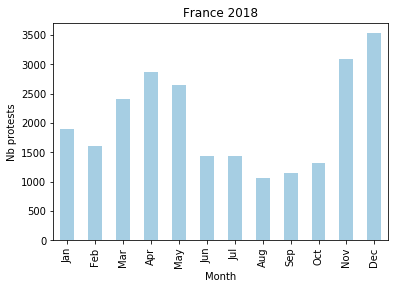

In [52]:
show_nb_protest_per_month(protests_df, CountryCode='FRA', year=2018)
plt.title('France 2018')
plt.show()

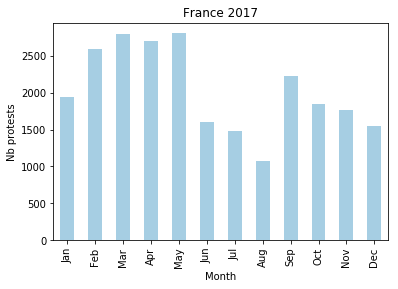

In [53]:
show_nb_protest_per_month(protests_df, CountryCode='FRA', year=2017)
plt.title('France 2017')
plt.show()

We clearly see the jellow jacket movement. The number of protests in December has mor than double compared to the previous year and the month is not over.

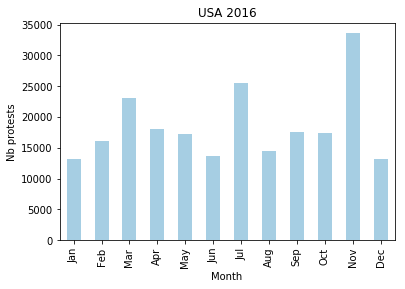

In [54]:
show_nb_protest_per_month(protests_df, CountryCode='USA', year=2016)
plt.title('USA 2016')
plt.show()

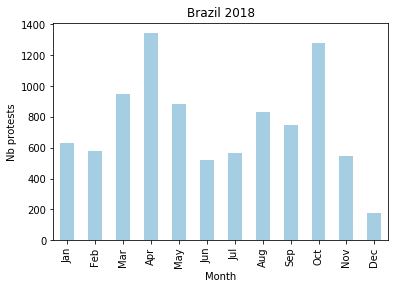

In [55]:
show_nb_protest_per_month(protests_df, CountryCode='BRA', year=2018)
plt.title('Brazil 2018')
plt.show()

We see two peaks in October the election of Jair Bolsonaro and in April the confirmation by the supreme court of the imprisonment of the ex president Lula.

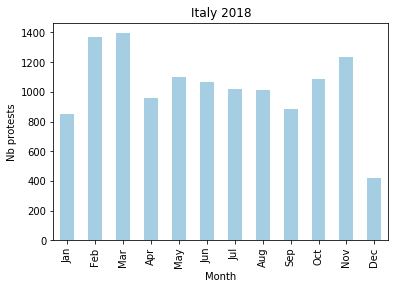

In [56]:
show_nb_protest_per_month(protests_df, CountryCode='ITA', year=2018)
plt.title('Italy 2018')
plt.show()

In March the election of the euroseptic government seems to have a far lesser impact as the last two elections.